# Visualize CNN
This notebook demonstrates how CNN extracts features from raw images. I will be going to dissect layer-by-layer and visulaize feature maps after each layer.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Dataset
I will be using the benchmark CIFAR-10 dataset which can be downloaded using the keras API. It consists of 50,000 training images and 10,000 test images. The dataset is well distributed with each of the 10 classes having 6000 images each.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


# Data normalization

In [ ]:
# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
print(f"Original training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Original training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


# Choosing a random test image

In [ ]:
# Select a random image from test set for visualization
test_idx = random.randint(0, len(x_test) - 1)
test_image = x_test[test_idx:test_idx+1]  # Keep batch dimension
test_label = y_test[test_idx]
true_class = class_names[np.argmax(test_label)]

In [ ]:
print(f"Selected test image index: {test_idx}")
print(f"True class: {true_class}")

Selected test image index: 1824
True class: truck


# Model

In [ ]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))  # Explicit input layer
    model.add(layers.Conv2D(32, (3, 3), activation=None, name='conv2d_1_pre_relu'))
    model.add(layers.Activation('relu', name='conv2d_1'))
    model.add(layers.MaxPooling2D((2, 2), name='maxpooling2d_1'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_2'))
    model.add(layers.MaxPooling2D((2, 2), name='maxpooling2d_2'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_3'))
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(64, activation='relu', name='dense_1'))
    model.add(layers.Dense(10, activation='softmax', name='dense_2'))
    return model

In [ ]:
# Create model
model = create_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1_pre_relu (Conv2D)      │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Activation)           │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpooling2d_1 (MaxPooling2D)   │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpooling2d_2 (MaxPooling2D)   │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

# Visualizer

In [ ]:
def visualize_layer_outputs(model, image, title_prefix="", max_filters=8):

    # Get outputs from all layers
    layer_outputs = []
    layer_names = []

    for layer in model.layers:
        if hasattr(layer, 'output'):
            layer_outputs.append(layer.output)
            layer_names.append(layer.name)

    # Create a model that returns the outputs of all layers
    activation_model = keras.Model(inputs=model.layers[0].input, outputs=layer_outputs)

    # Get activations
    activations = activation_model.predict(image, verbose=0)

    # Make prediction
    prediction = model.predict(image, verbose=0)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    print(f"\n{title_prefix}Prediction: {predicted_class} (Confidence: {confidence:.1f}%)")

    # Plot original image
    plt.figure(figsize=(20, 15))

    # Original image
    plt.subplot(3, 4, 1)
    plt.imshow(image[0])
    plt.title(f'Original Image\nShape: {image[0].shape}\nTrue class: {true_class}')
    plt.axis('off')

    plot_idx = 2

    for layer_name, activation in zip(layer_names, activations):
        if 'dense' in layer_name or 'flatten' in layer_name: continue

        if plot_idx > 12:  # Limit to available subplot positions
            break

        plt.subplot(3, 4, plot_idx)

        if len(activation.shape) == 4:  # Convolutional layers
            # For conv layers, show the first few feature maps
            n_features = min(max_filters, activation.shape[-1])

            if n_features == 1:
                plt.imshow(activation[0, :, :, 0], cmap='viridis')
            else:
                # Create a grid of feature maps
                size = int(np.ceil(np.sqrt(n_features)))
                fig_size = max(activation.shape[1], activation.shape[2])

                display_grid = np.zeros((size * fig_size, size * fig_size))

                for i in range(size):
                    for j in range(size):
                        if i * size + j < n_features:
                            channel_image = activation[0, :, :, i * size + j]
                            # Normalize for display
                            channel_image = (channel_image - channel_image.min()) / (channel_image.max() - channel_image.min() + 1e-8)
                            display_grid[i * fig_size: (i + 1) * fig_size,
                                       j * fig_size: (j + 1) * fig_size] = channel_image

                plt.imshow(display_grid, cmap='viridis')

            plt.title(f'{layer_name}\nShape: {activation.shape}')

        elif len(activation.shape) == 2:  # Dense layers
            # For dense layers, show as a bar plot
            plt.bar(range(len(activation[0])), activation[0])
            plt.title(f'{layer_name}\nShape: {activation.shape}')
            if layer_name == 'dense_2':  # Final layer
                plt.xticks(range(10), class_names, rotation=45)

        plt.axis('off')
        plot_idx += 1

    plt.tight_layout()
    plt.suptitle(f'{title_prefix}Layer Activations for Test Image', fontsize=16, y=1.02)
    plt.show()

# Visualization before training

VISUALIZATION BEFORE TRAINING

BEFORE TRAINING - Prediction: dog (Confidence: 11.3%)


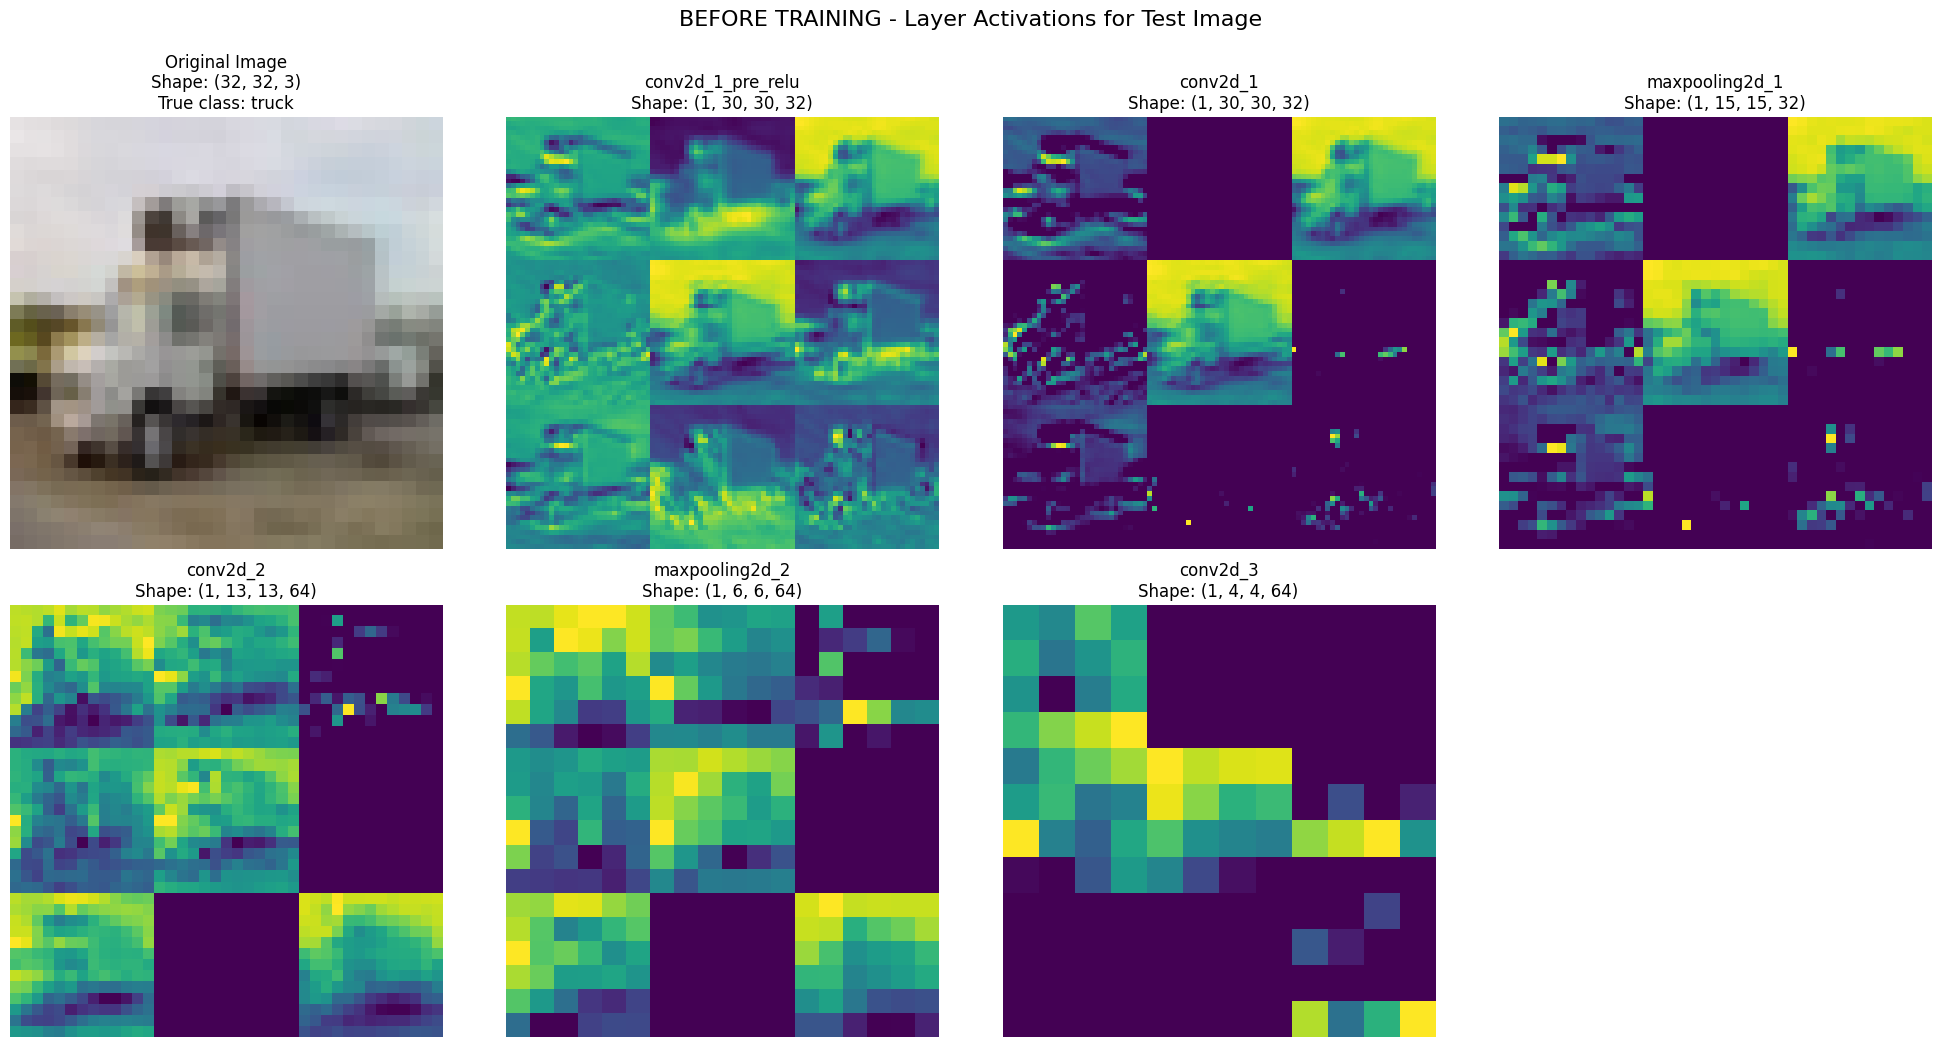

In [ ]:
print("=" * 60)
print("VISUALIZATION BEFORE TRAINING")
print("=" * 60)
visualize_layer_outputs(model, test_image, "BEFORE TRAINING - ", max_filters=9)

In [ ]:
# Check if GPU is available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Optional: Force GPU usage if available
if tf.config.list_physical_devices('GPU'):
    print("GPU will be used for training")
else:
    print("No GPU found, using CPU")

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
GPU will be used for training


# Training

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3178 - loss: 1.8401 - val_accuracy: 0.5005 - val_loss: 1.3807
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5275 - loss: 1.3137 - val_accuracy: 0.5686 - val_loss: 1.2185
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5991 - loss: 1.1331 - val_accuracy: 0.6158 - val_loss: 1.0920
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6378 - loss: 1.0249 - val_accuracy: 0.6394 - val_loss: 1.0162
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6684 - loss: 0.9459 - val_accuracy: 0.6520 - val_loss: 0.9874
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6913 - loss: 0.8770 - val_accuracy: 0.6600 - val_loss: 0.9722
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7138 - loss: 0.8224 - val_accuracy: 0.6588 - val_loss: 0.9771
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7320 - loss: 0.771

# Visulaization after training


VISUALIZATION AFTER TRAINING



AFTER TRAINING - Prediction: truck (Confidence: 99.1%)


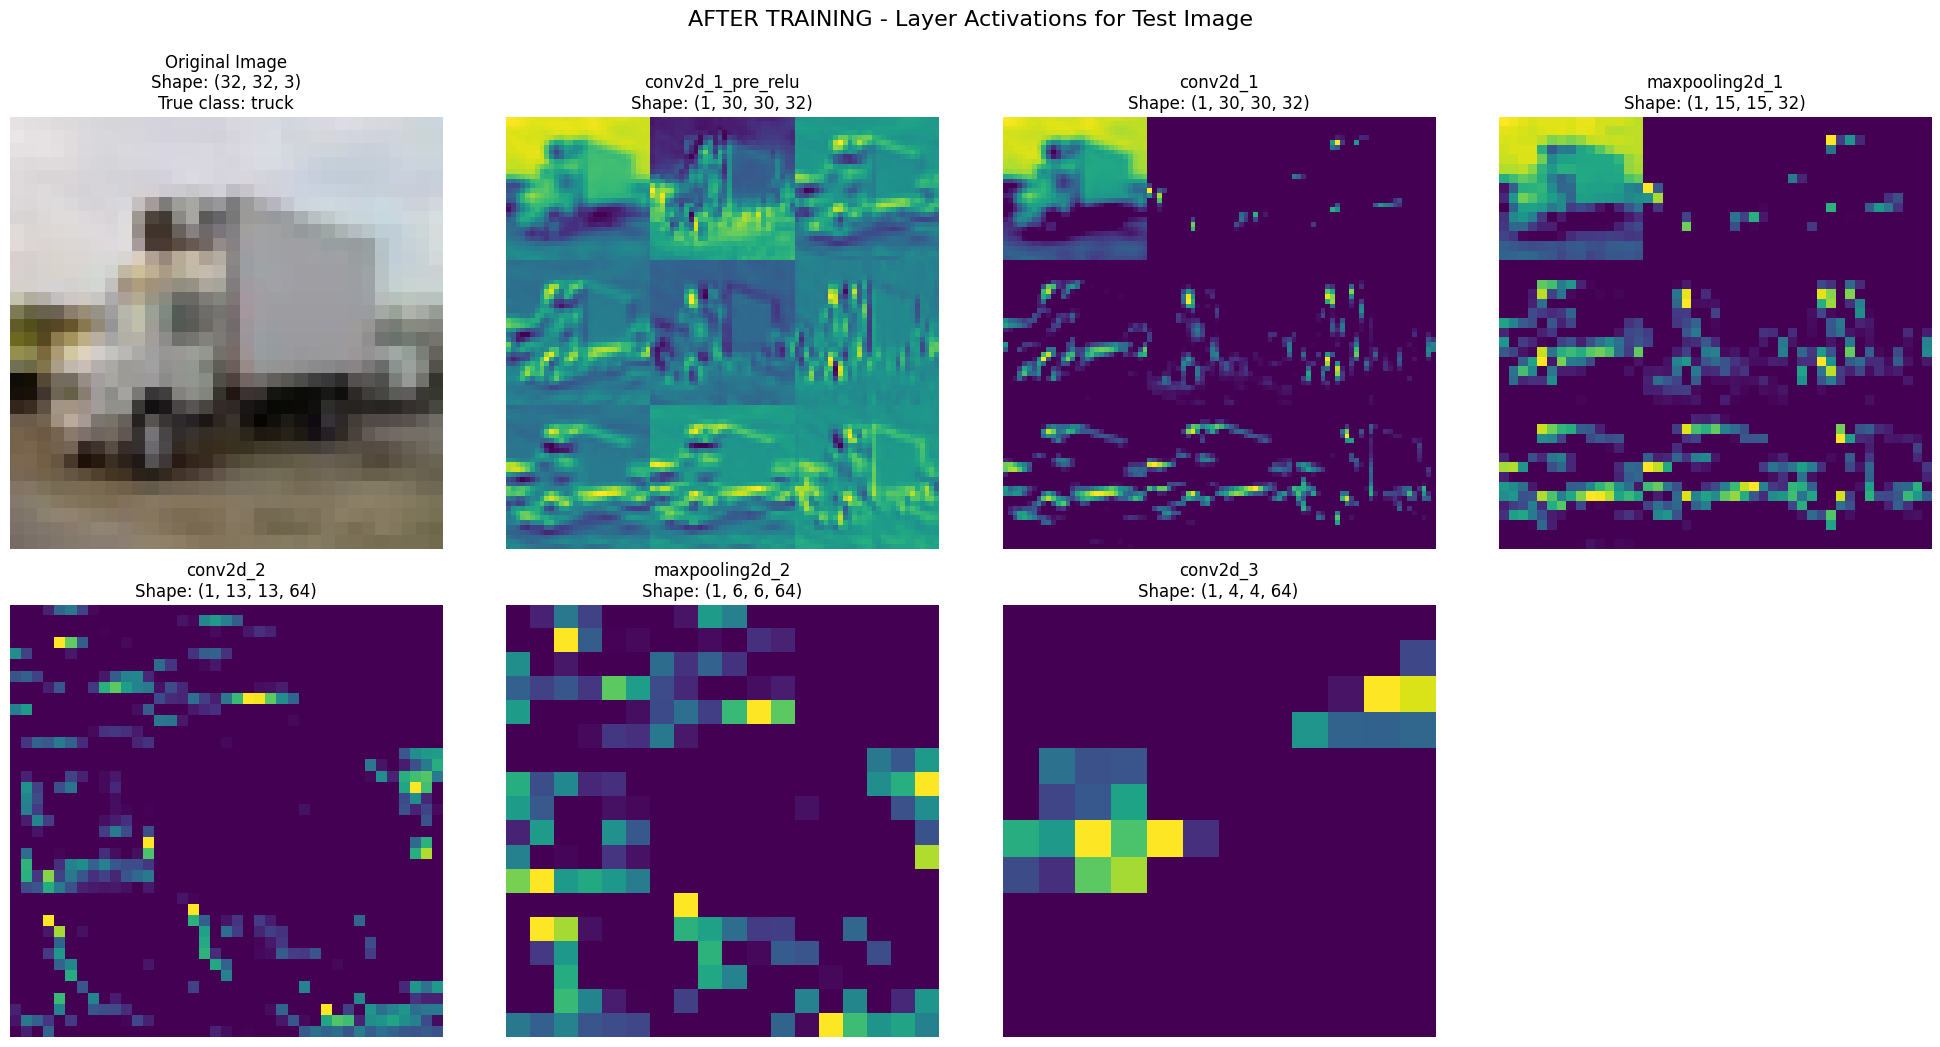

In [ ]:
print("\n" + "=" * 60)
print("VISUALIZATION AFTER TRAINING")
print("=" * 60)
visualize_layer_outputs(model, test_image, "AFTER TRAINING - ", max_filters=9)